# NLP Prediction of Disaster Tweets

### Introduction

Over the years, Twitter has grown to become an important medium of communication. Individuals are involved in reporting news even without noticing it. News from tweets can be even faster and more accurate than a traditional press. Therefore, many agencies are eager to monitor what's happening on tweets. However, this comes with its own complications. Distinguishing whether a person’s words are announcing real big news or just a type of word making jokes is a challenge. In this project, as an illustration, I'm going to analyze the unstructured data from tweets, to answer 'real or not' questions. The dataset was from [Kaggle](https://www.kaggle.com/c/nlp-getting-started/data) — the challenge with this dataset which tweets are real disasters and which ones are not. The two datasets that were given were test and train. It's meaningful as well as challenging to achieve such goals. The analyses of this dataset about disasters can be extended to many other topics. For instance, tweets can be used to trace how people think about covid-19 recently.

In this report, Some exploratory data analysis for the fundamental understanding of the dataset was applied to the training dataset. It includes text pre-processing and feature selections to find tokens that could help to create an accurate model later. Then the data was reconstructed as a new dataset for further applications. 

### Installations and modules

In [67]:
!pip install nltk
!pip install wordcloud
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
from collections import defaultdict, Counter
import nltk
from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

### Data Exploration

In [23]:
# import the data
train= pd.read_csv('./data/train.csv')

In [24]:
print('Number of Records in Train Dataset', len(train))

Number of Records in Train Dataset 7613


In [25]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [27]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [28]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Barplot of Missing Data in Keyword Column for Train Dataset

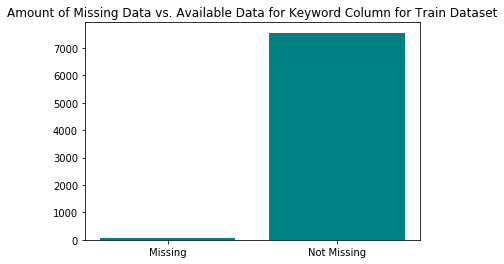

In [31]:
miss_train_keyword = train.iloc[:,1].isna().sum()
no_miss_train_keyword = train.iloc[:,1].notna().sum()

labels = ['Missing', 'Not Missing']
height = [miss_train_keyword, no_miss_train_keyword]

plt.bar(labels, height, color = 'teal')
plt.title('Amount of Missing Data vs. Available Data for Keyword Column for Train Dataset')
plt.show()


In the plot above, the 61 values of the keyword column for the train dataset is missing. But over 3500 values in the keyword column is available. About 0.017 of the data is missing within the keyword column of the train dataset. 

### Exploratory Analyses of the Keywords of the Tweets of both Test and Train Datasets

Total keywords in train set: 221


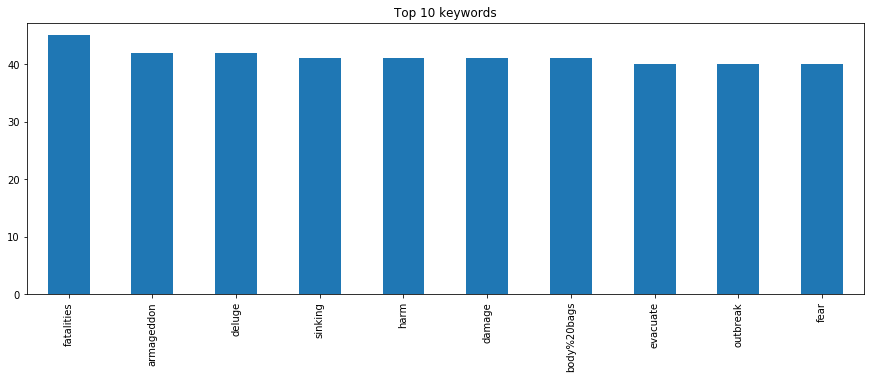

In [40]:
# Top 10 keywords in train
print(f"Total keywords in train set: {train.keyword.nunique()}")
fig, ax = plt.subplots(figsize=(15,5))
train.keyword.value_counts()[:10].plot(kind="bar")
ax.set_title("Top 10 keywords")
plt.show()

Test dataset has 3237 non-null objects for keywords, while train dataset has 7552 non-null objects. In the top-10 keyowrds, the number of these keywords from train data is approximately double these of test data. However, only one keyword "deluge" or "deluged" are related while others are irrelatant. Preliminarily, it can be assumed that keywords are not the best option to train and test the data. Our group will dig into the text of tweets for this project. 

### Target Label Summary

In [41]:
counts = train['target'].value_counts()
target_zero = counts[0]
target_one = counts[1]

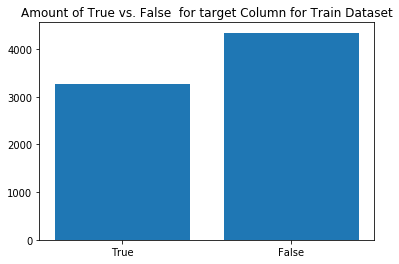

In [42]:
#Amount of True vs. False  for target Column for Train Dataset
labels = ['True','False' ]
height = [target_one, target_zero]

plt.bar(labels, height)
plt.title('Amount of True vs. False  for target Column for Train Dataset')
plt.show()

We can find that this dataset has nearly equal number of true and false for target column. The dataset don't have huge imbalance problem and we can use accuracy to measure how good the model is.

# Text Data Preprocessing

In [45]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
snow = nltk.stem.SnowballStemmer('english')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Drexel-
[nltk_data]     Bartoli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Drexel-
[nltk_data]     Bartoli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [46]:
def fix_Text(text):

  #Remove punctuation, symbols and numbers
	letters_only = re.sub("[^a-zA-Z]"," ", str(text))
  #convert to lowercase
	words=letters_only.lower().split()
  #Remove stop words, using Snowball Stemmer
	meaningful=[snow.stem(word) for word in words if word not in stop_words]
	return(" ".join(meaningful))

round1 = lambda x: fix_Text(x)

In [47]:
# test cleaning
clean= train.text.apply(round1)

In [50]:
clean[:15]

0             deed reason earthquak may allah forgiv us
1                  forest fire near la rong sask canada
2     resid ask shelter place notifi offic evacu she...
3           peopl receiv wildfir evacu order california
4     got sent photo rubi alaska smoke wildfir pour ...
5     rockyfir updat california hwi close direct due...
6     flood disast heavi rain caus flash flood stree...
7                                top hill see fire wood
8                emerg evacu happen build across street
9                              afraid tornado come area
10                        three peopl die heat wave far
11    haha south tampa get flood hah wait second liv...
12     rain flood florida tampabay tampa day lost count
13                        flood bago myanmar arriv bago
14               damag school bus multi car crash break
Name: text, dtype: object

# Word Cloud Visualization

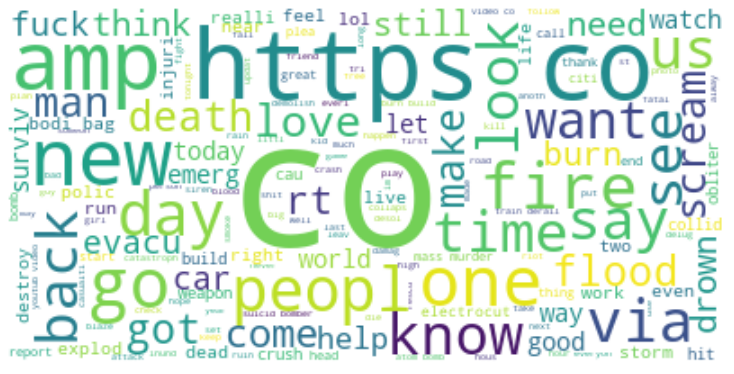

In [52]:
text_wc = " ".join(item for item in clean)
wordcloud = WordCloud(background_color="white").generate(text_wc)
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show() 

Besides the words realted to the disasters, some words or phrases such as https or co also have high frequency, as shown above. These are related to links or webpages, should be processed seperately or removed to the make the feature extraction having sense.

# Most common words

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Drexel-Bartoli\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


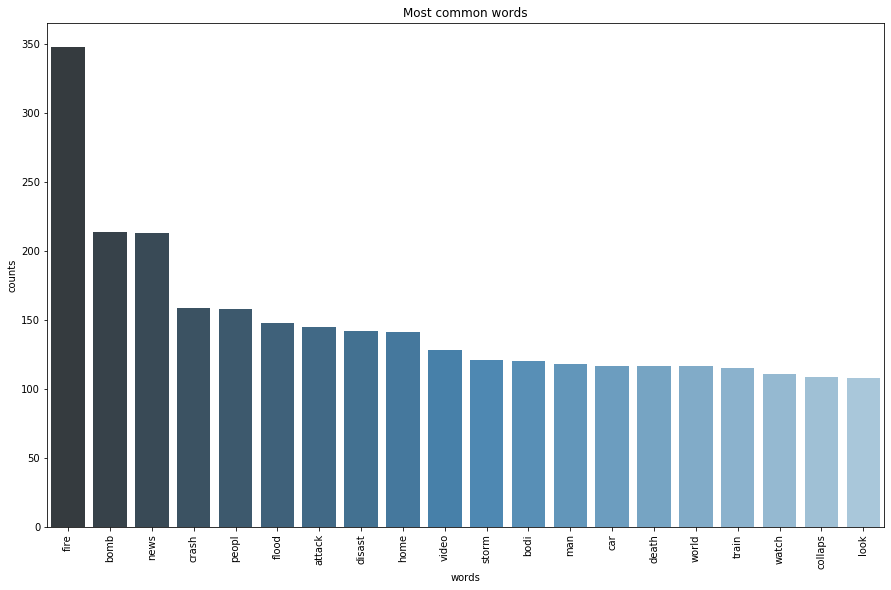

In [59]:
nltk.download('averaged_perceptron_tagger')

def plot_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='Most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette="Blues_d")
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Stop words for most common
stopwords_common = nltk.corpus.stopwords.words('english')
newStopWords = ['im','amp','https','http','co','time','year','day']
stopwords_common.extend(newStopWords)

# Pick out all the nouns
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)
train['clean'] = clean
data_nouns = pd.DataFrame(train.clean.apply(nouns))

cvn = CountVectorizer(stop_words=stopwords_common)
data_cvn = cvn.fit_transform(data_nouns.clean)
plot_most_common_words(data_cvn, cvn)

20 most common words are plotted above. It can be seen that (fire, bomb, news, crash, people, as first 5) these words are most likely related to the disaster. 

# Term Frequency-Inverse Document Frequency

Converts text documents into a Document-Term Matrix (DTM) 
Use Term Frequency-Inverse Document Frequency (tf-idf) tocapture term importance.

In [68]:
tfidfVec=TfidfVectorizer(min_df=100) # at least 100 occurences
tfidfdtm = tfidfVec.fit_transform(clean)
tfidfdtm

<7613x68 sparse matrix of type '<class 'numpy.float64'>'
	with 17681 stored elements in Compressed Sparse Row format>

In [70]:
# reconstruct the dataset and dispalying the first five rows
tfidf_df = pd.DataFrame(tfidfdtm.toarray(), columns=tfidfVec.get_feature_names())
tfidf_df.head()

,amp,attack,back,bag,bodi,bomb,build,burn,california,car,...,time,train,us,via,video,want,watch,world,would,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.599428,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Summary
The NLP datasets was first visualized with exploratory data analysis to get a comprehensive understanding of the data itself. Then processed with tokenization, text cleaning using extended stops words as well as remove the websites,  TfidfVectorizer and tf-idf to construct the words to features. For any text dataset, the above approach  is essential to the success of any following applications, such as trend analyses, political preference predictions, etc. 